# Extracting Time-Series from Cloud-Optimized GeoTIFFs (COGs)

## **Overview**

This notebook shows how to use XArray to efficiently extract pixels values from cloud-optimized GeoTIFF files hosted on cloud-buckets.

We want to sample pixel values from 12 individual GeoTIFF files representing Soil Moisture for each month of a year at multiple different locations. 




## Setup and Data Download

The following blocks of code will install the required packages and download the datasets to your Colab environment.

In [ ]:
%%capture
if 'google.colab' in str(get_ipython()):
    !pip install rioxarray

In [ ]:
import datetime
import glob
import os
import re
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import rioxarray as rxr
import zipfile

In [ ]:
data_folder = 'data'
output_folder = 'output'

if not os.path.exists(data_folder):
    os.mkdir(data_folder)
if not os.path.exists(output_folder):
    os.mkdir(output_folder)

# Data Pre-Processing

In this example, we have a folder on Google Cloud Storage (GCS) has 12 Cloud-Optomized GeoTIFF files representing soil moisture for each month. The file URIs are as below

```
gs://spatialthoughts-public-data/terraclimate/soil_moisture_202301.tif
gs://spatialthoughts-public-data/terraclimate/soil_moisture_202302.tif
gs://spatialthoughts-public-data/terraclimate/soil_moisture_202303.tif
...
```

First we create an XArray Dataset from these individual files.

The files will be read using the GDAL library which allows reading cloud-hosted files directly. Files on Google Cloud Storage can be read using the `/vsigs/` prefix. Since our files are public, we specify the `GS_NO_SIGN_REQUEST=YES` option. For accessing data on private bucket, see the authentication options specified in [GDAL and Google Cloud Storage (GCS)
](https://spatialthoughts.com/2024/02/26/gdal-google-cloud-storage/).

In [ ]:
os.environ['GS_NO_SIGN_REQUEST'] = 'YES'
prefix = '/vsigs/spatialthoughts-public-data/terraclimate/'

In [ ]:
# Create a list of URIs with /vgigs/ prefix
urls = []
for month in range(1, 13):
    image_id = f'soil_moisture_2023{month:02d}.tif'
    path = prefix + image_id
    urls.append(path)

urls

In [ ]:
def path_to_datetimeindex(filepath):
  filename = os.path.basename(filepath)
  pattern = r'soil_moisture_(\d+).tif'
  match = re.search(pattern, filepath)
  if match:
      doy_value = match.group(1)
      timestamp = datetime.datetime.strptime(doy_value, '%Y%m')
      return timestamp
  else:
    print('Could not extract DOY from filename', filename)


timestamps = []
filepaths = []

for filepath in urls:
  timestamp = path_to_datetimeindex(filepath)
  filepaths.append(filepath)
  timestamps.append(timestamp)

unique_timestamps = sorted(set(timestamps))

In [ ]:
scenes = []

for timestamp in unique_timestamps:
  filename = f'soil_moisture_{timestamp.strftime('%Y%m')}.tif'
  filepath = prefix + filename
  print(f'Reading {filepath}')
  scene = rxr.open_rasterio(filepath, chunks={'x':512, 'y':512})
  scenes.append(scene)

In [ ]:
time_var = xr.Variable('time', list(unique_timestamps))

time_series_scenes = xr.concat(scenes, dim=time_var)
time_series_scenes

## Plotting the time-series

We extract the time-series at a specific X,Y coordinate.

In [ ]:
time_series = time_series_scenes.interp(x=80.449, y=18.728)

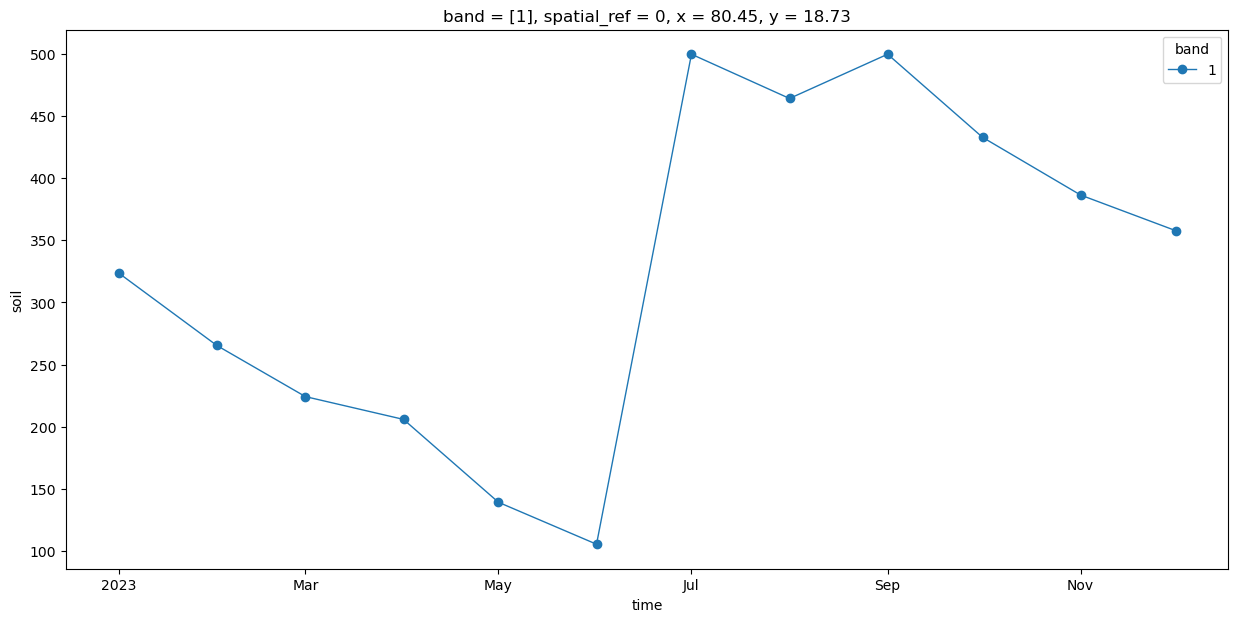

In [20]:
fig, ax = plt.subplots(1, 1)

fig.set_size_inches(15, 7)
time_series.plot.line(ax=ax, x='time', marker='o', linestyle='-', linewidth=1)
plt.show()

## Extracting Time-Series at Multiple Locations

In [ ]:
locations = [
    ('Location 1', 80.449, 18.728),
    ('Location 2', 79.1488, 15.2797),
    ('Location 3', 74.656, 25.144)
]

In [ ]:
df = pd.DataFrame(locations, columns=['Name', 'x', 'y'])
geometry = gpd.points_from_xy(df.x, df.y)
gdf = gpd.GeoDataFrame(df, crs='EPSG:4326', geometry=geometry)
gdf

In [ ]:
x_coords = gdf.geometry.x.to_xarray()
y_coords = gdf.geometry.y.to_xarray()

In [ ]:
sampled = time_series_scenes.sel(x=x_coords, y=y_coords, method='nearest')

Convert the sampled dataset to a Pandas Series.

In [ ]:
sampled_df = sampled.to_series()
sampled_df.name = 'soil_moisture'
sampled_df = sampled_df.reset_index()
sampled_df

Add a formatted time column

In [ ]:
sampled_df['formatted_time'] = sampled_df['time'].dt.strftime("%Y_%m")
sampled_df

Convert this to a wide table, with each month's value as a column.

In [ ]:
wide_df = sampled_df.pivot(index='index', columns='formatted_time', values='soil_moisture')
wide_df = wide_df.reset_index()
wide_df

Merge the extracted value with the original data.

In [ ]:
merged = pd.merge(gdf, wide_df, left_index=True, right_index=True)
merged

Finally, we save the sampled result to disk as a CSV.

In [ ]:
output_filename = 'soil_moisture.csv'
output_path = os.path.join(output_folder, output_filename)
output_df = merged.drop(columns=['geometry', 'index'])
output_df.to_csv(output_path, index=False)